# Boston 311 Tutorial

This notebook will run you through the basic usage of this package to train 4 models on the Boston 311 data and use them to predict the outcome of cases from the last 30 days

In [1]:
#The lifelines library is only needed for the Cox Regression Model, which is not included in this tutorial
#The keras-tuner library is needed for the neural network model
#The seaborn library is needed for visualization of results at the end
! pip install -q lifelines keras-tuner seaborn

In [2]:
! pip install git+https://github.com/mindfulcoder49/Boston_311.git

#! pip install . 

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/mindfulcoder49/Boston_311.git to /tmp/pip-req-build-yqs2mw83
  Running command git clone --filter=blob:none --quiet https://github.com/mindfulcoder49/Boston_311.git /tmp/pip-req-build-yqs2mw83
  Resolved https://github.com/mindfulcoder49/Boston_311.git to commit 8691dc6b1ab04820403acaec8416c96d20fc9717
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import the Boston311Model classes

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras_tuner import HyperParameters

Using TensorFlow backend


/home/briarmoss/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2023-11-04 10:32:30.875707: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-04 10:32:30.917684: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-04 10:32:30.918497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 10:32:31.420995: W tensorfl

In [4]:
from boston311 import Boston311LogReg, Boston311EventDecTree, Boston311SurvDecTree, Boston311KerasNN

## Get latest file URLS, Data, and Current Date Ranges

In [5]:
latest_URLS = Boston311LogReg().get311URLs()

trying to get csv URLs
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp_51lu33u.csv for year 2023
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv for year 2022
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv for year 2021
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv for year 2020
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv for year 2019
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/tmp7602cia8.csv f

In [6]:
print(latest_URLS)

{'2023': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp_51lu33u.csv', '2022': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv', '2021': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv', '2020': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv', '2019': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv', '2018': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/tmp7602cia8.csv', '2017': 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/300221

In [7]:
today_datestring, tomorrow_datestring, thirty_days_ago_datestring = Boston311LogReg().get_datestrings()

## Define several models

In [8]:
linear_tree_model = Boston311SurvDecTree(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type','queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0,
                                      'survivalTimeFill':tomorrow_datestring},
                            files_dict=latest_URLS)

hour_interval = 48
max_days = 120

linear_tree_model.bin_edges = linear_tree_model.generate_time_bins_fixed_interval(hour_interval, max_days)
linear_tree_model.bin_labels = linear_tree_model.generate_bin_labels(linear_tree_model.bin_edges)

In [9]:
logistic_model = Boston311LogReg(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type', 'queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0},
                            files_dict=latest_URLS)

In [10]:
logistic_tree_model = Boston311EventDecTree(train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring},
                            predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring},
                            feature_columns=['type', 'queue'],
                            scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']},
                                      'survivalTimeMin':0},
                            files_dict=latest_URLS)

## Load the data once and store it for use on all the models

In [11]:
all_2023_data = Boston311LogReg(train_date_range={'start':'2023-01-01','end':'2023-12-31'}).load_data()

Checking files_dict
files_dict is None
trying to call get311URLs
trying to get csv URLs
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp_51lu33u.csv for year 2023
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmpfm8veglw.csv for year 2022
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmp88p9g82n.csv for year 2021
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpcv_10m2s.csv for year 2020
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/tmpcje3ep_w.csv for year 2019
Found URL: https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resourc

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:334: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [12]:
prediction_data_2023 = linear_tree_model.load_data(data=all_2023_data, train_or_predict='predict')    

In [13]:
case_data_2023 = linear_tree_model.load_data(data=all_2023_data)

## Train several models

In [14]:
logistic_tree_model.run_pipeline(data=case_data_2023)

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])


Starting Training at 2023-11-04 10:33:02.530497
Testing accuracy: 0.9545906453029988
Ending Training at 2023-11-04 10:33:13.781418
Training took 0:00:11.250921


0.9545906453029988

In [15]:
logistic_tree_prediction = logistic_tree_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])
/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:265: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


In [16]:
logistic_tree_prediction['event_prediction'].value_counts()

event_prediction
1    19924
0     3396
Name: count, dtype: int64

In [17]:
logistic_tree_prediction[logistic_tree_prediction['event'] == 0].head(100)

,event_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
246315,0,101005095567,2023-10-05 00:53:00,2023-10-06 04:30:00,NaT,OVERDUE,Open,,Parking Enforcement,Transportation - Traffic Division,...,126-127 Newmarket Sq,2118.0,42.330461,-71.066839,0101000020E610000044591B1547C451C0590AE1874C2A...,Constituent Call,NaT,0,8,NaN
246365,1,101005095635,2023-10-05 03:34:51,2023-12-12 03:30:00,NaT,ONTIME,Open,,Graffiti Removal,Property Management,...,12 Tufts St,2111.0,42.351428,-71.057861,0101000020E6100000471477FDB3C351C0622A5398FB2C...,Citizens Connect App,NaT,0,3,NaN
246367,0,101005095640,2023-10-05 03:42:00,2024-01-03 02:42:26,NaT,ONTIME,Open,,SCH10/11Unsatisfactory Utilities - Electrical ...,Inspectional Services,...,351 W Second St,2127.0,42.338320,-71.046660,0101000020E6100000CD182D7CFCC251C00DDAB70D4E2B...,Constituent Call,NaT,0,6,NaN
246371,0,101005095645,2023-10-05 03:45:00,2023-10-06 04:30:00,NaT,OVERDUE,Open,,Sidewalk Repair (Make Safe),Public Works Department,...,63 Atlantic Ave,2110.0,42.362976,-71.051259,0101000020E6100000D8248DD247C351C075849400762E...,Constituent Call,NaT,0,3,NaN
246372,0,101005095646,2023-10-05 03:46:00,2023-10-24 04:30:00,NaT,OVERDUE,Open,,Abandoned Vehicles,Transportation - Traffic Division,...,9 Clematis St,2122.0,42.293380,-71.060801,0101000020E6100000C0043028E4C351C028B1DB758D25...,Citizens Connect App,NaT,0,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246935,0,101005096607,2023-10-05 10:41:00,NaN,NaT,ONTIME,Open,,Transportation General Request,Transportation - Traffic Division,...,97 Bradlee St,2136.0,42.270930,-71.117871,0101000020E6100000544CDE318BC751C0326F4DD2AD22...,Constituent Call,NaT,0,18,NaN
246939,1,101005096613,2023-10-05 10:47:00,2023-10-06 10:47:35,NaT,OVERDUE,Open,,Parking Enforcement,Transportation - Traffic Division,...,79 Claymoss Rd,2135.0,42.345140,-71.146221,0101000020E61000000AFDF4AD5BC951C0D0D41D892D2C...,Constituent Call,NaT,0,21,NaN
246941,0,101005096616,2023-10-05 10:48:00,2023-10-06 10:48:06,NaT,OVERDUE,Open,,Sidewalk Repair (Make Safe),Public Works Department,...,400 Huntington Ave,2115.0,42.339565,-71.089860,0101000020E6100000C5E6EE45C0C551C05BC0CBDF762B...,Constituent Call,NaT,0,4,NaN
246942,1,101005096621,2023-10-05 10:49:00,2023-10-20 10:49:46,NaT,OVERDUE,Open,,PRINTED : ED P. NOTIFIED,Public Works Department,...,INTERSECTION Opera Pl & Huntington Ave,NaN,42.340438,-71.088951,0101000020E610000036140A5EB1C551C04A00F777932B...,Constituent Call,NaT,0,4,NaN


In [18]:
logistic_tree_model.save('.','logtree','logtreeproperties')

In [19]:
logistic_model.run_pipeline(data=case_data_2023)

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])


Starting Training at 2023-11-04 10:33:15.620556
Epoch 1/10
4325/4325 [==============================] - 3s 592us/step - loss: 0.2350 - accuracy: 0.9196 - val_loss: 0.1424 - val_accuracy: 0.9394
Epoch 2/10
4325/4325 [==============================] - 2s 570us/step - loss: 0.1271 - accuracy: 0.9466 - val_loss: 0.1158 - val_accuracy: 0.9507
Epoch 3/10
4325/4325 [==============================] - 2s 559us/step - loss: 0.1104 - accuracy: 0.9525 - val_loss: 0.1073 - val_accuracy: 0.9528
Epoch 4/10
4325/4325 [==============================] - 2s 567us/step - loss: 0.1039 - accuracy: 0.9542 - val_loss: 0.1039 - val_accuracy: 0.9535
Epoch 5/10
4325/4325 [==============================] - 2s 565us/step - loss: 0.1008 - accuracy: 0.9557 - val_loss: 0.1023 - val_accuracy: 0.9536
Epoch 6/10
4325/4325 [==============================] - 2s 572us/step - loss: 0.0992 - accuracy: 0.9566 - val_loss: 0.1016 - val_accuracy: 0.9542
Epoch 7/10
4325/4325 [==============================] - 2s 571us/step - loss

0.9569027423858643

In [20]:
logistic_model.save('.','logreg','logregproperties')

In [21]:
logistic_prediction = logistic_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])
/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:265: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


729/729 [==============================] - 0s 335us/step


In [22]:
logistic_prediction[logistic_prediction['event_prediction'] < .5].shape[0]

1349

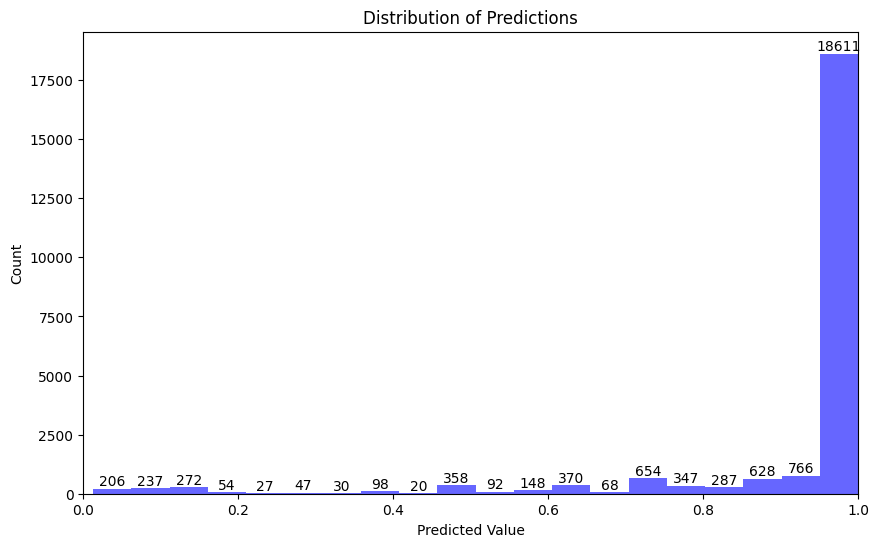

In [23]:
def plot_prediction_distribution(df, column):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the dataframe.")

    data = df[column]  # Extract the data from the dataframe

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(data, bins=20, alpha=0.6, color='b')

    # Add counts above the bins
    for count, rect in zip(n, patches):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, f'{int(count)}', ha='center', va='bottom')

    plt.title('Distribution of Predictions')
    plt.xlabel('Predicted Value')
    plt.ylabel('Count')
    plt.xlim(0, 1)  # Assuming the predictions are probabilities [0, 1]
    plt.show()

# Example usage:
plot_prediction_distribution(logistic_prediction, 'event_prediction')


In [24]:
linear_tree_model.run_pipeline(data=case_data_2023)

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])


Starting Training at 2023-11-04 10:33:43.707429
Testing accuracy: 0.6479387759820582
Ending Training at 2023-11-04 10:33:47.514088
Training took 0:00:03.806659


0.6479387759820582

In [25]:
linear_prediction = linear_tree_model.predict(data=prediction_data_2023)

columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])
/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:265: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


In [26]:
linear_prediction.head(20)

,survival_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
246307,0-2d,101005095558,2023-10-05 00:23:42,2023-10-06 04:30:00,2023-10-06 08:27:09,OVERDUE,Closed,Case Closed. Closed date : 2023-10-06 12:27:09...,Parking Enforcement,Transportation - Traffic Division,...,186 Havre St,2128.0,42.374298,-71.036792,0101000020E6100000375BECCC5AC251C0F91661FDE82F...,Citizens Connect App,1 days 08:03:27,1,1,32.057500
246308,0-2d,101005095559,2023-10-05 00:34:24,2023-10-10 04:30:00,2023-10-05 02:50:19,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 06:50:19...,Improper Storage of Trash (Barrels),Public Works Department,...,19 Old Landing Way,2129.0,42.379632,-71.054473,0101000020E61000003D55637C7CC351C0685782CB9730...,Citizens Connect App,0 days 02:15:55,1,2,2.265278
246309,0-2d,101005095560,2023-10-05 00:36:02,2023-10-10 04:30:00,2023-10-05 02:36:54,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 06:36:54...,Improper Storage of Trash (Barrels),Public Works Department,...,INTERSECTION Richfield St & Puritan Ave,NaN,42.307765,-71.071152,0101000020E6100000AB859EBF8DC451C07FCA73DB6427...,Citizens Connect App,0 days 02:00:52,1,15,2.014444
246310,0-2d,101005095561,2023-10-05 00:39:14,2023-10-10 04:30:00,2023-10-05 03:58:34,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 07:58:34...,Improper Storage of Trash (Barrels),Public Works Department,...,136 Newbury St,2116.0,42.350850,-71.076841,0101000020E610000076FE6FF4EAC451C049864DA3E82C...,Citizens Connect App,0 days 03:19:20,1,5,3.322222
246311,0-2d,101005095562,2023-10-05 00:42:14,2023-10-10 04:30:00,2023-10-05 03:15:44,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 07:15:44...,Improper Storage of Trash (Barrels),Public Works Department,...,83 Cambridge St,2129.0,42.382940,-71.077730,0101000020E61000004CF01389F9C451C0C2DEB6290431...,Citizens Connect App,0 days 02:33:30,1,2,2.558333
246312,0-2d,101005095563,2023-10-05 00:47:03,2023-10-10 04:30:00,2023-10-05 06:32:13,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 10:32:13...,Improper Storage of Trash (Barrels),Public Works Department,...,1758 River St,2136.0,42.243922,-71.138060,0101000020E6100000B6A72CF8D5C851C0CEF835D4381F...,Citizens Connect App,0 days 05:45:10,1,18,5.752778
246313,0-2d,101005095564,2023-10-05 00:48:51,2023-10-11 04:30:00,2023-10-05 11:58:32,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 15:58:32...,Poor Conditions of Property,Public Works Department,...,200-240 Meadow Rd,2136.0,42.231447,-71.134472,0101000020E61000004EDDEA319BC851C0FBEF610CA01D...,Citizens Connect App,0 days 11:09:41,1,18,11.161389
246314,0-2d,101005095565,2023-10-05 00:50:12,2023-10-10 04:30:00,2023-10-05 11:53:41,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 15:53:41...,Improper Storage of Trash (Barrels),Public Works Department,...,111 Business St,2136.0,42.251530,-71.129761,0101000020E6100000474E70004EC851C015AF791F3220...,Citizens Connect App,0 days 11:03:29,1,18,11.058056
246315,4w2d-4w4d,101005095567,2023-10-05 00:53:00,2023-10-06 04:30:00,NaT,OVERDUE,Open,,Parking Enforcement,Transportation - Traffic Division,...,126-127 Newmarket Sq,2118.0,42.330461,-71.066839,0101000020E610000044591B1547C451C0590AE1874C2A...,Constituent Call,NaT,0,8,NaN
246316,4w2d-4w4d,101005095569,2023-10-05 01:15:02,2023-10-20 04:30:00,2023-10-05 07:37:03,ONTIME,Closed,Case Closed. Closed date : 2023-10-05 11:37:03...,Sign Repair,Transportation - Traffic Division,...,1258 Commonwealth Ave,2134.0,42.349253,-71.132215,0101000020E61000002CC6793676C851C0F54E514EB42C...,Citizens Connect App,0 days 06:22:01,1,21,6.366944


In [27]:
linear_prediction.shape[0]

23320

In [28]:
logistic_prediction.shape[0]

23320

In [29]:
logistic_tree_prediction.shape[0]

23320

##Join the tables

In [30]:
merged_df = logistic_tree_prediction.merge(logistic_prediction[['case_enquiry_id','event_prediction']], on='case_enquiry_id', how="outer").merge(linear_prediction[['case_enquiry_id','survival_prediction']], on='case_enquiry_id', how="outer")

In [31]:
merged_df.shape[0]

23320

In [32]:
merged_df.head()

,event_prediction_x,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,...,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours,event_prediction_y,survival_prediction
0,1,101005095558,2023-10-05 00:23:42,2023-10-06 04:30:00,2023-10-06 08:27:09,OVERDUE,Closed,Case Closed. Closed date : 2023-10-06 12:27:09...,Parking Enforcement,Transportation - Traffic Division,...,42.374298,-71.036792,0101000020E6100000375BECCC5AC251C0F91661FDE82F...,Citizens Connect App,1 days 08:03:27,1,1,32.057500,0.999776,0-2d
1,1,101005095559,2023-10-05 00:34:24,2023-10-10 04:30:00,2023-10-05 02:50:19,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 06:50:19...,Improper Storage of Trash (Barrels),Public Works Department,...,42.379632,-71.054473,0101000020E61000003D55637C7CC351C0685782CB9730...,Citizens Connect App,0 days 02:15:55,1,2,2.265278,1.000000,0-2d
2,1,101005095560,2023-10-05 00:36:02,2023-10-10 04:30:00,2023-10-05 02:36:54,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 06:36:54...,Improper Storage of Trash (Barrels),Public Works Department,...,42.307765,-71.071152,0101000020E6100000AB859EBF8DC451C07FCA73DB6427...,Citizens Connect App,0 days 02:00:52,1,15,2.014444,1.000000,0-2d
3,1,101005095561,2023-10-05 00:39:14,2023-10-10 04:30:00,2023-10-05 03:58:34,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 07:58:34...,Improper Storage of Trash (Barrels),Public Works Department,...,42.350850,-71.076841,0101000020E610000076FE6FF4EAC451C049864DA3E82C...,Citizens Connect App,0 days 03:19:20,1,5,3.322222,1.000000,0-2d
4,1,101005095562,2023-10-05 00:42:14,2023-10-10 04:30:00,2023-10-05 03:15:44,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 07:15:44...,Improper Storage of Trash (Barrels),Public Works Department,...,42.382940,-71.077730,0101000020E61000004CF01389F9C451C0C2DEB6290431...,Citizens Connect App,0 days 02:33:30,1,2,2.558333,1.000000,0-2d


##Save the prediction data

In [33]:
merged_df.to_csv('predictions.csv', index=False)

In [34]:
import gc
gc.collect()

55

# Enter the Neural Network #

In [35]:
KerasNN_model = Boston311KerasNN()

In [36]:
KerasNN_model.train_date_range={'start':'2023-01-01','end':thirty_days_ago_datestring}

KerasNN_model.predict_date_range={'start':thirty_days_ago_datestring,'end':today_datestring}

KerasNN_model.feature_columns=['queue', 'type']

KerasNN_model.scenario={'dropColumnValues': {'source':['City Worker App', 'Employee Generated']}, 'survivalTimeMin':0, 'survivalTimeFill':tomorrow_datestring}

KerasNN_model.epochs = 2
KerasNN_model.batch_size = 32

In [37]:

hour_interval = 48
max_days = 120

#KerasNN_model.bin_edges = KerasNN_model.generate_time_bins_statistics(df, num_intervals=60)
KerasNN_model.bin_edges = KerasNN_model.generate_time_bins_fixed_interval(hour_interval, max_days)

start_nodes = 256
end_nodes = 128
#l2_0 = 0.00001
#learning_rate = 7.5842e-05
l2_0 = 0.001
learning_rate = 0.0001

hp = HyperParameters()
hp.Fixed('start_nodes', start_nodes)
hp.Fixed('end_nodes', end_nodes)
hp.Fixed('l2_0', l2_0)
hp.Fixed('learning_rate', learning_rate)
bin_number = len(KerasNN_model.bin_edges) - 1
hp.Fixed('final_layer', bin_number)
hp.Fixed('final_activation', 'softmax')
KerasNN_model.best_hyperparameters = hp

In [38]:
KerasNN_model.run_pipeline(data=case_data_2023)

bin_labels is None


/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])


Starting Training at 2023-11-04 10:33:50.789922
input_dim: 334
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               85760     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 61)                7869      
                                                                 
Total params: 126525 (494.24 KB)
Trainable params: 126525 (494.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
<class 'pandas.core.frame.DataFrame'> (173001, 61)
<class 'pandas.core.frame.DataFrame'> (43251, 61)
run fit

Epoch 1/2
5407/5407 [==============================] - 11s 2ms/step - loss: 1.7208 - accuracy: 0.597

0.6120321154594421

In [39]:
predictions, data = KerasNN_model.predict(data=prediction_data_2023)

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_dt'] = pd.to_datetime(data['open_dt'])


columns in data before drop: Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'survival_time',
       'event', 'ward_number', 'survival_time_hours'],
      dtype='object')
columns to drop: Index(['case_status', 'case_title', 'city_council_district', 'closed_dt',
       'closed_photo', 'closure_reason', 'department', 'fire_district',
       'geom_4326', 'latitude', 'location', 'location_street_name',
       'location_zipcode', 'longitude', 'neighborhood',
       'neighborhood_services_district', 'on_time', 'open_dt',
       'police_distric

/home/briarmoss/.local/lib/python3.10/site-packages/boston311/Boston311Model.py:265: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, fake_df], ignore_index=True)


729/729 [==============================] - 0s 501us/step


In [40]:
def get_top_predictions(bin_labels, predictions):
    # Check if the number of columns in predictions matches the length of bin_labels
    if len(bin_labels) != predictions.shape[1]:
        raise ValueError("The length of bin_labels must be equal to the number of columns in predictions")

    # Get the indices of the top 3 predictions for each row
    top_3_indices = np.argsort(-predictions, axis=1)[:, :3]

    # Map the indices to labels
    top_3_labels = np.array(bin_labels)[top_3_indices]

    return top_3_labels

def add_prediction_columns(cases_df, top_predictions):
    # Check if the number of rows in the DataFrame matches the number of predictions
    if cases_df.shape[0] != top_predictions.shape[0]:
        raise ValueError("The number of rows in cases_df must be equal to the number of predictions")

    # Create new columns for the predictions
    #cases_df['1st_prediction'] = top_predictions[:, 0]
    #cases_df['2nd_prediction'] = top_predictions[:, 1]
    #cases_df['3rd_prediction'] = top_predictions[:, 2]
    #use insert instead to put them on the left side
    cases_df.insert(0, '1st_prediction', top_predictions[:, 0])
    cases_df.insert(1, '2nd_prediction', top_predictions[:, 1])
    cases_df.insert(2, '3rd_prediction', top_predictions[:, 2])
    
    return cases_df

prediction_labels = get_top_predictions(KerasNN_model.bin_labels, predictions)
df_predictions = add_prediction_columns(data, prediction_labels)

In [41]:
df_predictions.shape[0]

23320

In [42]:
df_predictions.head(100)

,1st_prediction,2nd_prediction,3rd_prediction,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,...,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,survival_time,event,ward_number,survival_time_hours
246307,0-2d,2d-4d,4d-6d,101005095558,2023-10-05 00:23:42,2023-10-06 04:30:00,2023-10-06 08:27:09,OVERDUE,Closed,Case Closed. Closed date : 2023-10-06 12:27:09...,...,186 Havre St,2128.0,42.374298,-71.036792,0101000020E6100000375BECCC5AC251C0F91661FDE82F...,Citizens Connect App,1 days 08:03:27,1,1,32.057500
246308,0-2d,2d-4d,4d-6d,101005095559,2023-10-05 00:34:24,2023-10-10 04:30:00,2023-10-05 02:50:19,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 06:50:19...,...,19 Old Landing Way,2129.0,42.379632,-71.054473,0101000020E61000003D55637C7CC351C0685782CB9730...,Citizens Connect App,0 days 02:15:55,1,2,2.265278
246309,0-2d,2d-4d,4d-6d,101005095560,2023-10-05 00:36:02,2023-10-10 04:30:00,2023-10-05 02:36:54,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 06:36:54...,...,INTERSECTION Richfield St & Puritan Ave,NaN,42.307765,-71.071152,0101000020E6100000AB859EBF8DC451C07FCA73DB6427...,Citizens Connect App,0 days 02:00:52,1,15,2.014444
246310,0-2d,2d-4d,4d-6d,101005095561,2023-10-05 00:39:14,2023-10-10 04:30:00,2023-10-05 03:58:34,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 07:58:34...,...,136 Newbury St,2116.0,42.350850,-71.076841,0101000020E610000076FE6FF4EAC451C049864DA3E82C...,Citizens Connect App,0 days 03:19:20,1,5,3.322222
246311,0-2d,2d-4d,4d-6d,101005095562,2023-10-05 00:42:14,2023-10-10 04:30:00,2023-10-05 03:15:44,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 07:15:44...,...,83 Cambridge St,2129.0,42.382940,-71.077730,0101000020E61000004CF01389F9C451C0C2DEB6290431...,Citizens Connect App,0 days 02:33:30,1,2,2.558333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246408,0-2d,2d-4d,4d-6d,101005095698,2023-10-05 04:12:18,2023-10-10 04:30:00,2023-10-05 06:45:30,ONTIME,Closed,Case Closed. Closed date : Thu Oct 05 10:45:30...,...,179 Northampton St,2118.0,42.337410,-71.079071,0101000020E61000005C2DE27D0FC551C014D8703C302B...,Citizens Connect App,0 days 02:33:12,1,9,2.553333
246409,0-2d,2d-4d,4d-6d,101005095700,2023-10-05 04:12:53,2023-10-06 04:30:00,2023-10-06 08:28:23,OVERDUE,Closed,Case Closed. Closed date : 2023-10-06 12:28:23...,...,37 McBride St,2130.0,42.305860,-71.113661,0101000020E61000007E417B3746C751C03E0E4A682627...,Citizens Connect App,1 days 04:15:30,1,11,28.258333
246410,over 114y24w2d16h,0-2d,6d-1w1d,101005095702,2023-10-05 04:14:00,2024-02-02 03:14:51,2023-10-10 11:47:43,ONTIME,Closed,Case Closed. Closed date : Tue Oct 10 15:47:43...,...,365 Centre St,2122.0,42.294516,-71.058108,0101000020E61000003211E509B8C351C033C828B1B225...,Constituent Call,5 days 07:33:43,1,16,127.561944
246411,0-2d,2d-4d,4d-6d,101005095704,2023-10-05 04:15:00,2023-10-06 04:30:00,2023-10-05 04:54:46,ONTIME,Closed,Case Closed. Closed date : 2023-10-05 08:54:46...,...,45 Harbor View St,2125.0,42.316970,-71.054561,0101000020E6100000989473EB7DC351C06A0D09759228...,Constituent Call,0 days 00:39:46,1,13,0.662778


In [43]:
#add the three prediction columns to the merged_df by merging on case_enquiry_id
merged_df = merged_df.merge(df_predictions[['case_enquiry_id','1st_prediction','2nd_prediction','3rd_prediction']], on='case_enquiry_id', how="outer")

In [44]:
# Select and view the first 20 records of the specified columns
columns_to_view = ['1st_prediction', '2nd_prediction', '3rd_prediction', 'survival_prediction', 'event_prediction_x', 'event_prediction_y', 'case_enquiry_id','open_dt','closed_dt','survival_time','case_title','type','queue']
merged_df[columns_to_view].head(20)


,1st_prediction,2nd_prediction,3rd_prediction,survival_prediction,event_prediction_x,event_prediction_y,case_enquiry_id,open_dt,closed_dt,survival_time,case_title,type,queue
0,0-2d,2d-4d,4d-6d,0-2d,1,0.999776,101005095558,2023-10-05 00:23:42,2023-10-06 08:27:09,1 days 08:03:27,Parking Enforcement,Parking Enforcement,BTDT_Parking Enforcement
1,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005095559,2023-10-05 00:34:24,2023-10-05 02:50:19,0 days 02:15:55,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
2,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005095560,2023-10-05 00:36:02,2023-10-05 02:36:54,0 days 02:00:52,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
3,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005095561,2023-10-05 00:39:14,2023-10-05 03:58:34,0 days 03:19:20,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
4,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005095562,2023-10-05 00:42:14,2023-10-05 03:15:44,0 days 02:33:30,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
5,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005095563,2023-10-05 00:47:03,2023-10-05 06:32:13,0 days 05:45:10,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
6,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005095564,2023-10-05 00:48:51,2023-10-05 11:58:32,0 days 11:09:41,Poor Conditions of Property,Poor Conditions of Property,PWDx_Code Enforcement
7,0-2d,2d-4d,4d-6d,0-2d,1,1.000000,101005095565,2023-10-05 00:50:12,2023-10-05 11:53:41,0 days 11:03:29,Improper Storage of Trash (Barrels),Improper Storage of Trash (Barrels),PWDx_Code Enforcement
8,0-2d,over 114y24w2d16h,2d-4d,4w2d-4w4d,0,0.460869,101005095567,2023-10-05 00:53:00,NaT,NaT,Parking Enforcement,Parking Enforcement,BTDT_Permits & Special Events
9,0-2d,2d-4d,4d-6d,4w2d-4w4d,1,0.999260,101005095569,2023-10-05 01:15:02,2023-10-05 07:37:03,0 days 06:22:01,Sign Repair,Sign Repair,BTDT_District 01


In [45]:
#now show the first 20 that have event=0
merged_df[merged_df['event'] == 0][columns_to_view].head(20)

,1st_prediction,2nd_prediction,3rd_prediction,survival_prediction,event_prediction_x,event_prediction_y,case_enquiry_id,open_dt,closed_dt,survival_time,case_title,type,queue
8,0-2d,over 114y24w2d16h,2d-4d,4w2d-4w4d,0,0.460869,101005095567,2023-10-05 00:53:00,NaT,NaT,Parking Enforcement,Parking Enforcement,BTDT_Permits & Special Events
53,over 114y24w2d16h,0-2d,2d-4d,4w2d-4w4d,1,0.802387,101005095635,2023-10-05 03:34:51,NaT,NaT,Graffiti Removal,Graffiti Removal,PROP_GRAF_GraffitiRemoval
55,0-2d,over 114y24w2d16h,2d-4d,0-2d,0,0.687943,101005095640,2023-10-05 03:42:00,NaT,NaT,SCH10/11Unsatisfactory Utilities - Electrical ...,Unsatisfactory Utilities - Electrical Plumbing,ISD_Housing (INTERNAL)
59,over 114y24w2d16h,0-2d,2d-4d,4w2d-4w4d,0,0.461084,101005095645,2023-10-05 03:45:00,NaT,NaT,Sidewalk Repair (Make Safe),Sidewalk Repair (Make Safe),PWDx_Sidewalk Repair
60,0-2d,over 114y24w2d16h,1w5d-2w,4w2d-4w4d,0,0.927039,101005095646,2023-10-05 03:46:00,NaT,NaT,Abandoned Vehicles,Abandoned Vehicles,BTDT_AVRS Interface Queue
61,over 114y24w2d16h,0-2d,2d-4d,4w2d-4w4d,0,0.040592,101005095648,2023-10-05 03:47:00,NaT,NaT,Requests for Traffic Signal Studies or Reviews,Requests for Traffic Signal Studies or Reviews,INFO_Mass DOT
72,over 114y24w2d16h,0-2d,2d-4d,4w2d-4w4d,0,0.116927,101005095666,2023-10-05 03:54:00,NaT,NaT,Requests for Street Cleaning,Requests for Street Cleaning,INFO_Mass DCR
74,over 114y24w2d16h,0-2d,2d-4d,4w2d-4w4d,0,0.461084,101005095667,2023-10-05 03:54:00,NaT,NaT,Sidewalk Repair (Make Safe),Sidewalk Repair (Make Safe),PWDx_Sidewalk Repair
93,over 114y24w2d16h,0-2d,2d-4d,4w2d-4w4d,0,0.639675,101005095694,2023-10-05 04:08:26,NaT,NaT,Tree Maintenance Requests,Tree Maintenance Requests,PARK_Tree Maintenance Request
103,over 114y24w2d16h,0-2d,2d-4d,5w1d-5w3d,0,0.172085,101005095711,2023-10-05 04:18:00,NaT,NaT,Pick up Dead Animal,Pick up Dead Animal,INFO_Mass DCR


In [46]:


def plot_prediction_distribution(df, prediction_cols):
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Create figure and axes
    fig, axes = plt.subplots(nrows=len(prediction_cols), figsize=(10, 5 * len(prediction_cols)))

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    # Plot the distribution of each prediction
    for ax, col in zip(axes, prediction_cols):
        sns.countplot(data=df, x=col, hue=col, palette="viridis", order=df[col].value_counts().index, ax=ax, legend=False)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('Labels')
        ax.set_ylabel('Frequency')
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        plt.xticks(rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

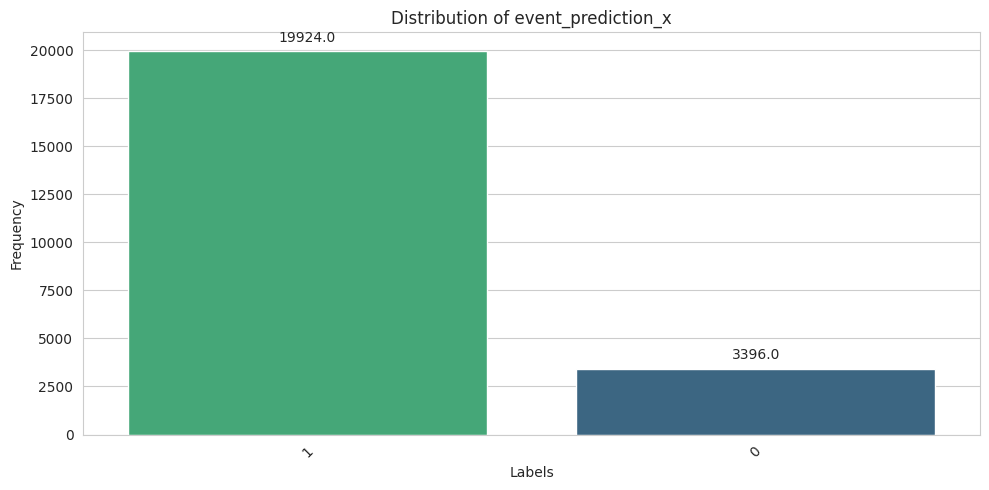

In [47]:
# Assuming `merged_df` is your DataFrame with columns '1st_prediction', '2nd_prediction', '3rd_prediction'
# Example usage:
plot_prediction_distribution(merged_df, ['event_prediction_x'])

In [48]:
merged_df['survival_prediction'].value_counts()

survival_prediction
0-2d                  12365
4w2d-4w4d              3945
3w1d-3w3d              2093
6d-1w1d                1775
7w3d-7w5d              1509
2w-2w2d                 368
1w5d-2w                 329
2w4d-2w6d               307
8w6d-9w1d               226
7w1d-7w3d               160
2d-4d                   119
4w4d-4w6d                37
5w1d-5w3d                24
10w2d-10w4d              13
2w6d-3w1d                10
5w3d-5w5d                 7
4w6d-5w1d                 7
5w5d-6w                   4
3w3d-3w5d                 4
9w1d-9w3d                 3
6w-6w2d                   3
8w-8w2d                   3
17w1d-114y24w2d16h        3
1w3d-1w5d                 2
8w4d-8w6d                 1
15w1d-15w3d               1
4w-4w2d                   1
6w6d-7w1d                 1
Name: count, dtype: int64

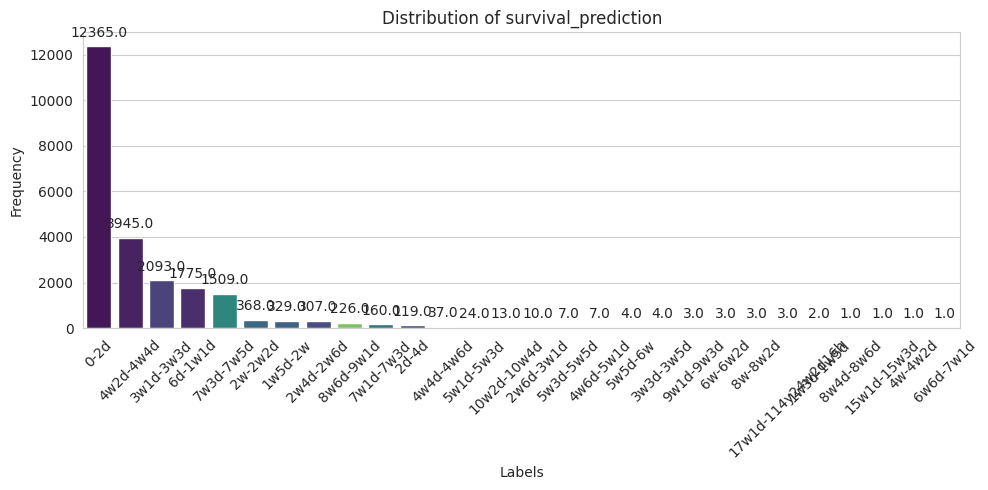

In [49]:

plot_prediction_distribution(merged_df, ['survival_prediction'])

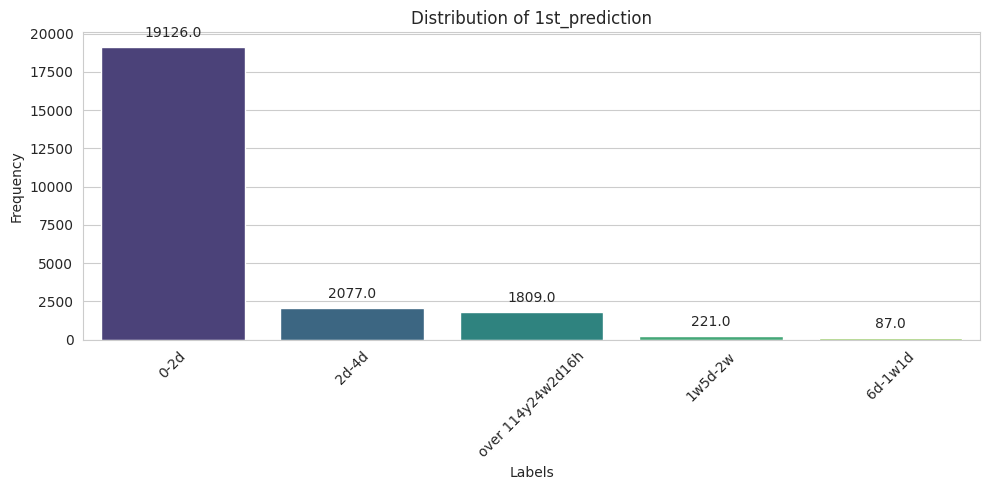

In [50]:

plot_prediction_distribution(merged_df, ['1st_prediction'])

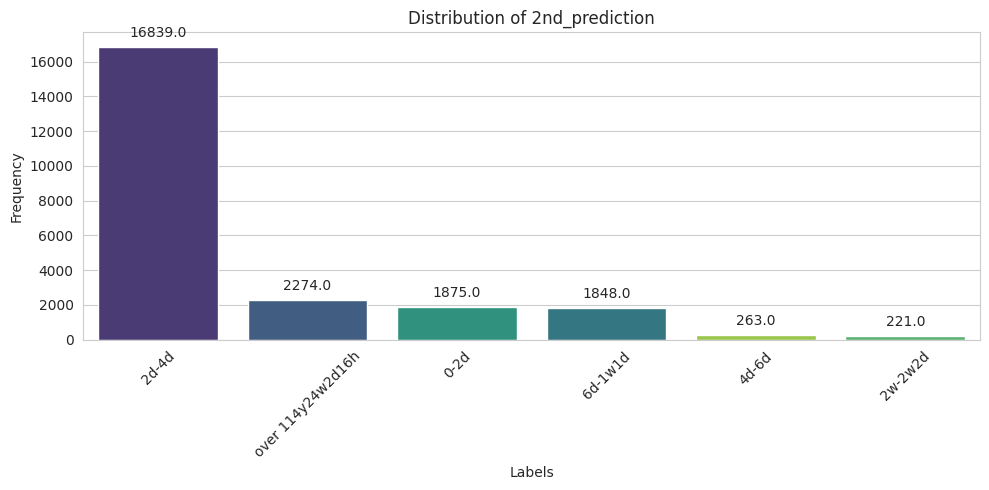

In [51]:

plot_prediction_distribution(merged_df, ['2nd_prediction'])

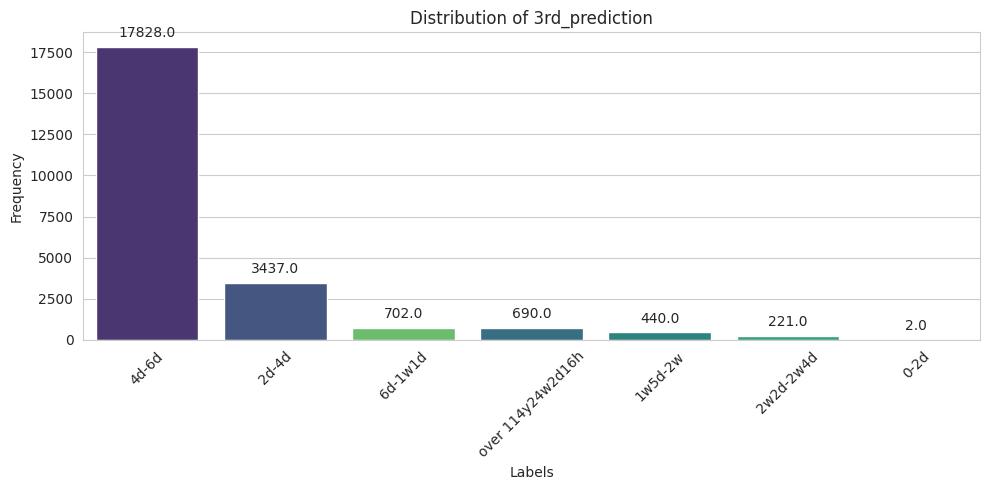

In [52]:

plot_prediction_distribution(merged_df, ['3rd_prediction'])